In [1]:
# Import Libraries
import rasterio
import numpy as np
import xarray as xr
import netCDF4 as nc
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj

from multiprocessing import Pool
from matplotlib.colors import LinearSegmentedColormap
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform, Resampling
from rasterio.transform import from_origin
from rasterio.windows import Window
from rasterio.mask import mask
from rasterio.plot import show
from scipy.ndimage import zoom
from shapely.geometry import box


In [ ]:
# Import Michele's VHR Snow Depth Data (Apr 9, 2022)
#file_path = '/Users/marzi/Desktop/MichelleBPR_VHRsnd/report_roughproducts/BPR_20220409_develproducts/20220409_1746_1040010074206D00_10400100768BBB00-DEM_3m_processedSnowDepth.tif'

### Plot Original VHR Snow Depth GeoTIFF (April 9, 2021)

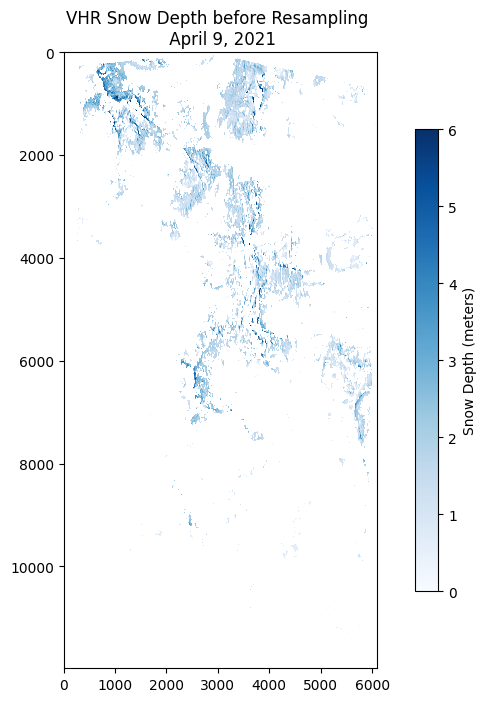

In [2]:

# Path to your GeoTIFF file
file_path = '/Users/marzi/Desktop/MichelleBPR_VHRsnd/report_roughproducts/BPR_20220409_develproducts/20220409_1746_1040010074206D00_10400100768BBB00-DEM_3m_processedSnowDepth.tif'

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    # Read the data
    snow_depth = src.read(1, masked=True)

    # Plot the GeoTIFF image
    plt.figure(figsize=(10, 8))
    img_plot = plt.imshow(snow_depth, cmap='Blues', vmin=0, vmax=6)

    # Add colorbar
    cbar = plt.colorbar(img_plot, shrink=0.75)
    cbar.set_label('Snow Depth (meters)')

    # Add title and labels
    plt.title('VHR Snow Depth before Resampling \n April 9, 2021')
    
    # Show the plot
    plt.show()


### Check & Compare Coordinate Systems

In [3]:
# Path to your GeoTIFF file
VHR_path = '/Users/marzi/Desktop/MichelleBPR_VHRsnd/report_roughproducts/BPR_20220409_develproducts/20220409_1746_1040010074206D00_10400100768BBB00-DEM_3m_processedSnowDepth.tif'

S1_path = '/Users/marzi/Desktop/Apr52021_BPR_snd.tif'

# Open the GeoTIFF file
with rasterio.open(VHR_path) as src:
    # Get the CRS
    crs1 = src.crs

    # Print the CRS
    print("VHR File Coordinate Reference System (CRS):", crs1)

with rasterio.open(S1_path) as src:
    # Get the CRS
    crs2 = src.crs

    # Print the CRS
    print("S1 File Coordinate Reference System (CRS):", crs2)

VHR File Coordinate Reference System (CRS): EPSG:32613
S1 File Coordinate Reference System (CRS): EPSG:4326


### Convert GeoTIFF Coordinate System
Reproject and remove 0 values along the boundaries from the conversion

In [4]:

def reproject_geotiff(input_path, output_path, target_crs):
    # Open the input GeoTIFF file
    with rasterio.open(input_path) as src:
        # Calculate the transform for the target coordinate system
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )

        # Create an array to store the reprojected data
        reprojected_data = np.zeros((height, width), dtype=src.read(1).dtype)

        # Reproject the data
        reproject(
            source=rasterio.band(src, 1),
            destination=reprojected_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest,
        )

        # Remove zero values on the boundaries
        reprojected_data[reprojected_data == 0] = np.nan

        # Update metadata for the output GeoTIFF
        dst_meta = src.meta.copy()
        dst_meta.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height,
        })

        # Write the reprojected data to the output GeoTIFF file
        with rasterio.open(output_path, 'w', **dst_meta) as dst:
            dst.write(reprojected_data, 1)

# Example usage
input_geotiff = '/Users/marzi/Desktop/MichelleBPR_VHRsnd/report_roughproducts/BPR_20220409_develproducts/20220409_1746_1040010074206D00_10400100768BBB00-DEM_3m_processedSnowDepth.tif'  # Provide the path to your input GeoTIFF file
output_geotiff = '/Users/marzi/Desktop/WGS84_VHR.tif'  # Provide the desired path for the output GeoTIFF file
target_crs = 'EPSG:4326'  # Change this to your desired target CRS

reproject_geotiff(input_geotiff, output_geotiff, target_crs)


### Check Resolution of GeoTIFF

In [5]:
def get_geotiff_resolution(geotiff_path):
    with rasterio.open(geotiff_path) as src:
        # Retrieve pixel scale from the GeoTIFF metadata
        pixel_width, pixel_height = src.transform.a, src.transform.e

        # Get linear units from the GeoTIFF metadata
        linear_units = src.crs.linear_units

    return pixel_width, pixel_height, linear_units

# Example usage
geotiff_path = '/Users/marzi/Desktop/WGS84_VHR.tif'
pixel_width, pixel_height, linear_units = get_geotiff_resolution(geotiff_path)

print(f"Pixel Width: {pixel_width} {linear_units}")
print(f"Pixel Height: {pixel_height} {linear_units}")


Pixel Width: 2.864431738765572e-05 unknown
Pixel Height: -2.864431738765572e-05 unknown


### Resample VHR Snow Depth (GeoTIFF)

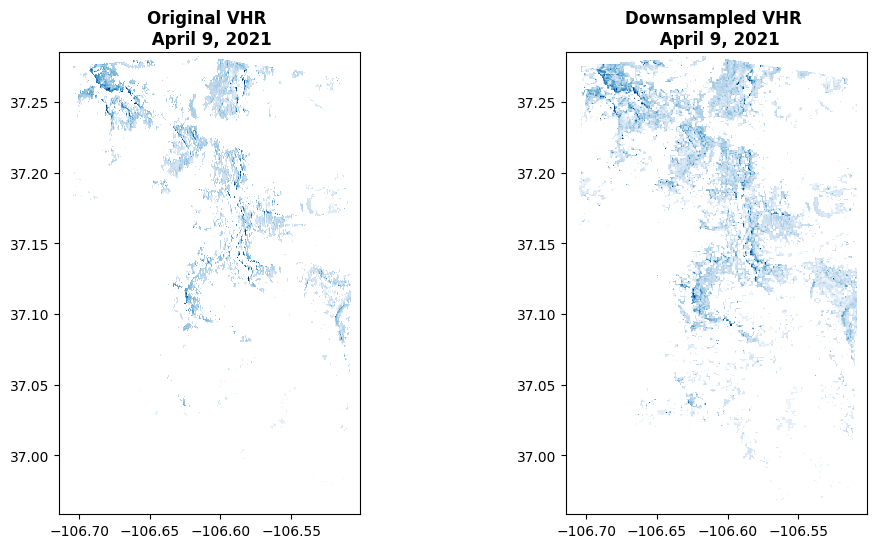

In [26]:
def downsample_geotiff_and_plot(input_path, output_path, factor=30):
    # Open the input GeoTIFF file
    with rasterio.open(input_path) as src:
        # Read the raster data
        data = src.read()

        # Calculate the new dimensions after downsampling
        new_height = data.shape[1] // factor
        new_width = data.shape[2] // factor

        # Perform downsampling using scipy.ndimage.zoom
        downsampled_data = zoom(data, (1, 1/factor, 1/factor), order=1)

        # Update the transform for the new resolution
        new_transform = src.transform * src.transform.scale(
            (src.width / new_width), (src.height / new_height))

        # Update the metadata
        new_meta = src.meta.copy()
        new_meta.update({
            'driver': 'GTiff',
            'height': new_height,
            'width': new_width,
            'transform': new_transform
        })

        # Write the downsampled data to a new GeoTIFF file
        with rasterio.open(output_path, 'w', **new_meta) as dst:
            dst.write(downsampled_data)

    # Plot the original and downsampled GeoTIFFs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Original GeoTIFF
    with rasterio.open(input_path) as src:
        show(src, ax=ax1, cmap='Blues', title="Original VHR \n April 9, 2021", vmin=0, vmax=6)

    # Downsampled GeoTIFF
    with rasterio.open(output_path) as downsampled_src:
        show(downsampled_src, ax=ax2, cmap='Blues', title="Downsampled VHR \n April 9, 2021", vmin=0, vmax=6)

    plt.show()

# Example usage
input_geotiff_path = '/Users/marzi/Desktop/WGS84_VHR.tif'
output_geotiff_path = '/Users/marzi/Desktop/resampled_VHR.tif'

downsample_geotiff_and_plot(input_geotiff_path, output_geotiff_path)


### Clip S1 GeoTIFF with VHR GeoTIFF

In [22]:
def clip_geotiff(input_path, clip_extent_path, output_path):
    # Open the input GeoTIFF file for reading
    with rasterio.open(input_path) as src:
        # Read the clip extent file
        with rasterio.open(clip_extent_path) as clip_src:
            # Get the bounding box of the clip extent
            bounds = clip_src.bounds

            # Calculate the window to read from the input GeoTIFF
            window = src.window(*bounds)

            # Read the data from the input GeoTIFF within the clip extent
            data = src.read(1, window=window)

            # Update the transform with the new origin and resolution
            transform = from_origin(bounds.left, bounds.top, src.transform.a, -src.transform.e)  # Negate the pixel height to flip the image

            # Update the metadata
            metadata = src.meta.copy()
            metadata.update({
                'driver': 'GTiff',
                'height': data.shape[0],
                'width': data.shape[1],
                'transform': transform,
            })

            # Create a new GeoTIFF file for writing
            with rasterio.open(output_path, 'w', **metadata) as dst:
                # Write the clipped data to the output GeoTIFF
                dst.write(data, 1)


# Example usage:
input_geotiff_path = '/Users/marzi/Desktop/Apr52021_BPR_snd.tif'
clip_extent_geotiff_path = '/Users/marzi/Desktop/resampled_VHR.tif'
output_geotiff_path = '/Users/marzi/Desktop/clipped_Apr52021_S1snd.tif'

clip_geotiff(input_geotiff_path, clip_extent_geotiff_path, output_geotiff_path)




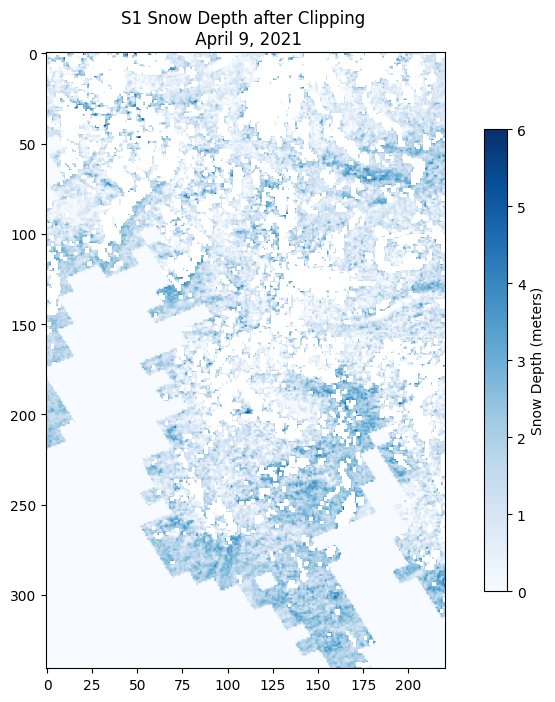

In [27]:

# Path to your GeoTIFF file
file_path = '/Users/marzi/Desktop/clipped_Apr52021_S1snd.tif'

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    # Read the data
    snow_depth = src.read(1, masked=True)

    # Plot the GeoTIFF image
    plt.figure(figsize=(10, 8))
    img_plot = plt.imshow(snow_depth, cmap='Blues', vmin=0, vmax=6)

    # Add colorbar
    cbar = plt.colorbar(img_plot, shrink=0.75)
    cbar.set_label('Snow Depth (meters)')

    # Add title and labels
    plt.title('S1 Snow Depth after Clipping \n April 9, 2021')
    
    # Show the plot
    plt.show()